# Clustering

### Purpose: To perform appropriate clustering operations on several different datasets and to provide a rationale for your model selection and evaluation decisions. Additional questions are included to evaluate understanding of selected clustering concepts/methods.

The prompts require the exercise of 'best professional judgement' in relation to the decision-making and modeling process.

Please note that there are a wide variety of clustering algorithms available, each with various strengths and weaknesses. This focuses on a limited subset of common clustering algorithms: Kmeans, Gaussian Mixture Model, DBSCAN, and Agglomerative Hierarchical.

#### Learning Objectives:
- Apply appropriate steps to clean and/or prepare data for cluster analyses.
- Undertake exploratory data analysis to support model selection.
- Select an appropriate clustering and evaluation method(s) for a given dataset.
- Validate model results following clustering when labelled data is available.
- Discuss the strengths/weaknesses of various clustering methods.
- Leverage clustering methods for outlier detection.

In [1]:
# import known needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score

In [2]:
# functions for plotting gaussian mixture model clusterings
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label= True, ax= None):
    ax = ax #or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=1, alpha= 0.4)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.3 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor, ax= ax)

## Problem 1a: Kmeans

Load in the dataset: 'x1_vals.npy'.

In [3]:
# load in dataset
x1 = np.load('x1_vals.npy')
x1

array([[-1.2420542 ,  1.21236828],
       [-0.78606585,  0.97868587],
       [ 1.89945366,  3.55757059],
       ...,
       [ 4.18468868,  6.48023715],
       [ 2.83799136,  7.63914652],
       [ 3.70848389,  6.86437973]])

In [4]:
# load in labels
y1 = np.load('y1_vals.npy')

In [5]:
# create dataframe from dataset
x1_df = pd.DataFrame(x1, columns= ['x1', 'x2'])
x1_df.head()

,x1,x2
0,-1.242054,1.212368
1,-0.786066,0.978686
2,1.899454,3.557571
3,-2.385988,1.549266
4,0.233876,0.539165


In [6]:
# scale data
std_scaler = StandardScaler()
x1_scaled = pd.DataFrame(std_scaler.fit_transform(x1_df[['x1', 'x2']]), columns= ['x1', 'x2'])
x1_scaled.head()

,x1,x2
0,-1.437393,-1.166966
1,-1.303608,-1.252367
2,-0.515689,-0.309900
3,-1.773017,-1.043845
4,-1.004362,-1.412992


In [7]:
# add labels to dataframe
x1_scaled['label'] = y1

Conduct an initial exploratory data analysis (EDA) to evaluate the data. Create at least two different types of visualizations to help you evaluate possible values for K (the number of clusters). Implement two different analytical methods to narrow your choice of K prior to modeling.

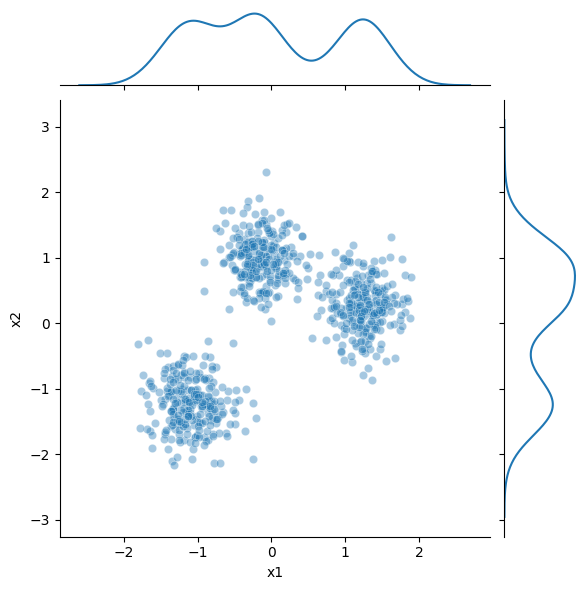

In [8]:
# examine density plot
g = sns.JointGrid(data= x1_scaled, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha= 0.4)
g.plot_marginals(sns.kdeplot);

From our EDA, we can see three blobs, of about the same density (the one centered along the x1 axis near -1, could be slightly less dense than the other two). The density plots along the edges of the graph support the data being roughly the same density, as slight overlap between two groups on each axis cause an increase in the density plot (i.e., blobs centered along the x1 axis near -1 and 0 as well as blobs centered along the x2 axis near 1 and 0).

Now we will estimate K from KMeans Inertia and Silhouette Analysis.

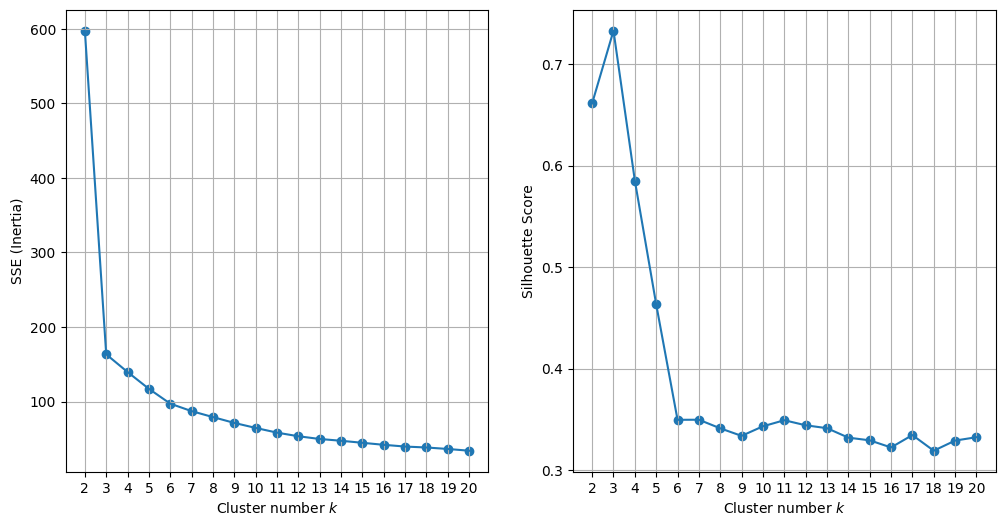

In [9]:
# attempt kmeans to get SSE(Inertia) and Silhouette Score
sse_sil = np.empty((0, 3))
for k in np.arange(2, 21, 1):
    kmeans_est = KMeans(n_clusters= k, n_init= 10)
    kmeans_est.fit(x1_scaled)
    labels = kmeans_est.labels_

    sse_sil = np.vstack([sse_sil, np.array([k, kmeans_est.inertia_, silhouette_score(x1_scaled, labels)])])

fig, (ax1, ax2) = plt.subplots(nrows= 1, ncols= 2, figsize= (12, 6))

ax1.scatter(x= sse_sil[:, 0], y= sse_sil[:, 1])
ax1.plot(sse_sil[:, 0], sse_sil[:, 1])
ax1.grid()
ax1.set_xlabel('Cluster number $k$')
ax1.set_ylabel('SSE (Inertia)')
ax1.set_xticks(ticks= np.arange(2, 21, 1))

ax2.scatter(x= sse_sil[:, 0], y= sse_sil[:, 2])
ax2.plot(sse_sil[:, 0], sse_sil[:, 2])
ax2.grid()
ax2.set_xlabel('Cluster number $k$')
ax2.set_ylabel('Silhouette Score')
ax2.set_xticks(ticks= np.arange(2, 21, 1))
plt.show()

In [10]:
# get max silhouette score
sse_sil[sse_sil[:, 2].argmax()]

array([  3.        , 163.32659893,   0.73297564])

From our SSE(Inertia) plot it's difficult to see much difference between 3, 4, or even 5. The Silhouette Score agrees with our EDA estimate of 3 clusters.

Let's try to identify k with the AIC and BIC.

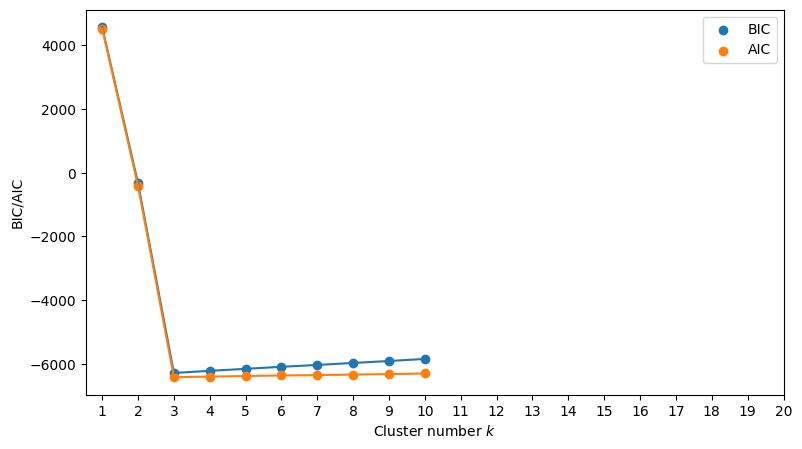

In [11]:
# identify best k with AIC and BIC
bic_aic = np.empty((0, 3))
for k in np.arange(start= 1, stop= 11, step= 1, dtype= int):
    gm_est = GaussianMixture(n_components= k).fit(x1_scaled)
    bic_aic = np.vstack([bic_aic, np.array([k, gm_est.bic(x1_scaled), gm_est.aic(x1_scaled)])])

plt.figure(figsize= (9, 5))
plt.scatter(x= bic_aic[:, 0], y= bic_aic[:, 1], label= 'BIC')
plt.plot(bic_aic[:, 0], bic_aic[:, 1])
plt.scatter(x= bic_aic[:, 0], y= bic_aic[:, 2], label= 'AIC')
plt.plot(bic_aic[:, 0], bic_aic[:, 2])
plt.xlabel('Cluster number $k$')
plt.ylabel('BIC/AIC')
plt.xticks(ticks= np.linspace(1, 20, 20, dtype= int))
plt.legend()
plt.show()

In [12]:
## BIC Minimum
print(bic_aic[bic_aic[:, 1].argmin()])

## AIC Minimum
print(bic_aic[bic_aic[:, 2].argmin()])

[ 3.00000000e+00 -6.28584250e+03 -6.41982463e+03]
[ 3.00000000e+00 -6.28584250e+03 -6.41982463e+03]


The AIC and BIC agree with a k of 3. Thus we will cluster with optimal number of k=3.

Use scikit-learn to fit a basic kmeans clustering model with random initialization and reproducible results. Then create a plot of your results that distinguishes each of the clusters by color. Extract values for your cluster centroids, the number of iterations to convergence, as well as a value that serves as a measure of cluster 'coherence'.

#### Fit KMeans with 3 clusters

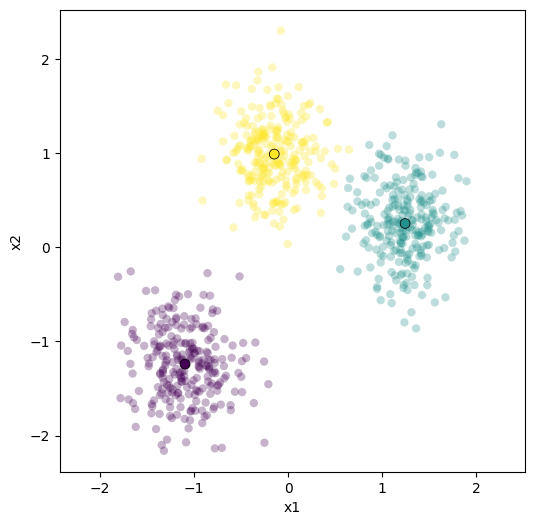

In [13]:
kmeans = KMeans(n_clusters= 3, init= 'random', n_init= 'auto', random_state= 42)
kmeans.fit(x1_scaled)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

fig, ax = plt.subplots(1, 1, figsize= (6, 6))
sns.scatterplot(x= x1_scaled.x1, y= x1_scaled.x2, c= labels, alpha= 0.3, ax= ax, edgecolor= 'none')
sns.scatterplot(x= centers[:, 0], y= centers[:, 1], c= np.unique(labels), ax= ax, s= 50, edgecolor= 'black')
plt.axis('equal')
plt.show()

Extract values for your cluster centroids, the number of iterations to convergence, as well as a value that serves as a measure of cluster 'coherence'.

In [14]:
# extract values for cluster centroids
for centroid in kmeans.cluster_centers_:
    cluster = centroid
    x1 = cluster[0]
    x2 = cluster[1]
    label = int(cluster[2])
    print(f'Cluster {label}\'s centroid is located at: ({x1}, {x2})')

Cluster 0's centroid is located at: (-1.0955067236645726, -1.2410080495640345)
Cluster 1's centroid is located at: (1.2423429083074415, 0.25210859382337963)
Cluster 2's centroid is located at: (-0.14683618464286818, 0.9888994557406495)


In [15]:
# extract the number of iterations to convergence:
print(f'The number of interations to convergence: {kmeans.n_iter_}')

The number of interations to convergence: 5


In [16]:
# calculate Davies-Bouldin score for measure of cluster 'coherence'
davies_bouldin = davies_bouldin_score(X= x1_scaled[['x1', 'x2']], labels= x1_scaled.label)
davies_bouldin

0.4518675176766804

### Questions:

#### A. What method(s) did you use to indentify an appropriate value for K? Why did you select this method? (5pts)
- I used a combination of the elbow method, silhouette score, and AIC/BIC along with the EDA method to make sure I wasn't overlooking an abnormalities in the data. These methods all have different strengths and weaknesses and are best when used together.

#### B. What value did you select for K? Does your EDA support this choice? (2pts)
- I selected k = 3, which is supported by my EDA.

#### C. How many iterations were required before your model converged? (2pts)
Five iterations were required before my model converged.

#### D. What were the values for each of your cluster centroids? (2pts)
- Cluster 0's centroid is located at: (-1.0955067236645726, -1.2410080495640345)- 
Cluster 1's centroid is located at: (1.2423429083074415, 0.25210859382337963
- 
Cluster 2's centroid is located at: (-0.14683618464286818, 0.9888994557406495)

#### E. What kmeans measure serves as a proxy for cluster coherence? What value did your model return? Discuss your interpretation of this value. (5pts)

## Problem 1b: Silhouette Plot

Using the data and kmeans model from Problem 1a, create a set of silhouette plots (i.e., an appropriate range of k values) by adapting the following code for your use:

C:\Users\farrj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\farrj\AppData\Local\Temp\ipykernel_27124\3212825528.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color= plt.cm.get_cmap("Spectral")(float(j)/ k)
C:\Users\farrj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to

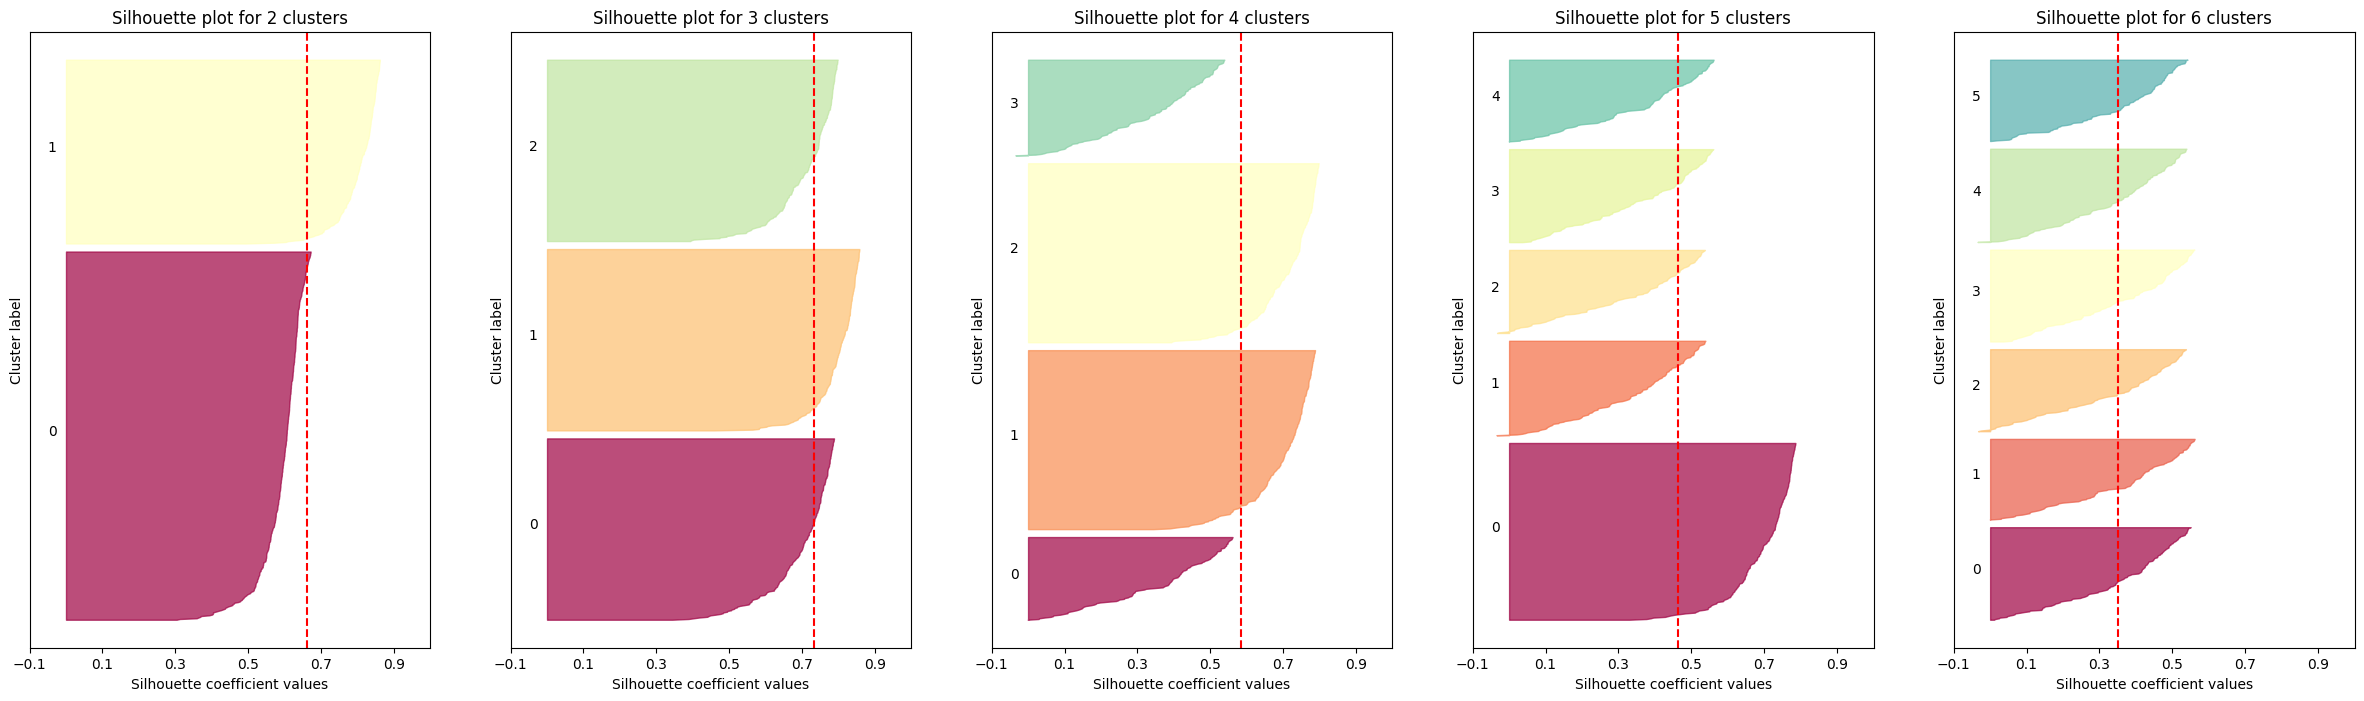

In [17]:
silhouette_value_by_k = np.empty((0, 2))

k_values = np.arange(2, 7, 1)
plt.figure(figsize= (len(k_values)*6, 8))

for i, k in enumerate(k_values):
    # initialize the clusterer
    clusterer = KMeans(n_clusters= k, random_state= 42)
    cluster_labels= clusterer.fit_predict(x1_scaled)

    # compute the silhouette scores
    silhouette_avg= silhouette_score(x1_scaled, cluster_labels)
    sample_silhouette_values= silhouette_samples(x1_scaled, cluster_labels)

    silhouette_value_by_k = np.vstack([silhouette_value_by_k, [k, sample_silhouette_values.mean()]])

    plt.subplot(1, len(k_values), i+1)
    y_lower = 10

    for j in range(k):
        ith_cluster_silhouette_values= sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_j= ith_cluster_silhouette_values.shape[0]
        y_upper= y_lower + size_cluster_j

        color= plt.cm.get_cmap("Spectral")(float(j)/ k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor= color,
            edgecolor= color, alpha= 0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower= y_upper + 10

    plt.title("Silhouette plot for {} clusters".format(k))
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x= silhouette_avg, color= "red", linestyle= "--")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.xlim([-0.1, 1.0])

plt.show()

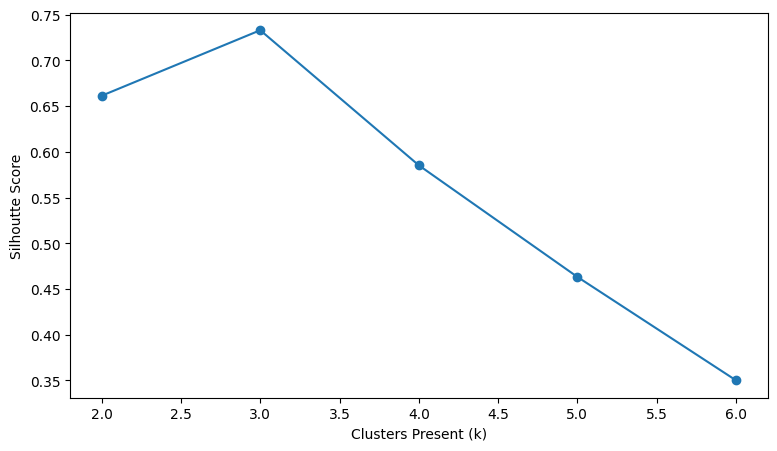

In [18]:
plt.figure(figsize= (9, 5))
plt.scatter(x= silhouette_value_by_k[:, 0], y= silhouette_value_by_k[:, 1])
plt.plot(silhouette_value_by_k[:, 0], silhouette_value_by_k[:, 1])
plt.ylabel('Silhoutte Score')
plt.xlabel('Clusters Present (k)')
plt.show()

### Questions:

#### A. What information does a silhouette analysis provide? (5pts)

A silhouette analysis provides information on cluster cohesion (on average how far are the data points in one cluster from each other) as well as cluster separation (on average how far are the data points in one cluster from the data points in another cluster).

#### B. Describe how to interpret the individual silhouette plots in terms of cluster cohesion and separation. What are the key features of the graphs that aid your evaluation? (5pts)

The key things to look at in a silhouette plot are:
- The thickness of each different colored chunk, this tells you about the overall density of the clusters. In this case, clustering with 3 or 6 clusters results in roughly even density distributions.
- Where the tips of each different colored chunk lie compared to the red dotted line (the average silhouette score overall). Noteably, in the clustering of 6, the average silhouette score is lower while the average shilhouette score for the clustering of 3 is higher (which you can also see in the scatter plot above).
- Additionally, in the clusterings of 4 and more, some of the colored chunks have small sections that point backwards, intdicating the data that was assigned incorrectly.

#### C. From the silhouette plots you created, what value of K affords the best cluster assignments? (3pts)

The silhouette plots created confirmed a value of k = 3 for best clustering assignment.

## Problem 2: External Validation

When labels are available to distinguish groupings within a dataset, external cluster validation can be used to evaluate how well clustering results match the external criteria. In this problem, you will create a synthetic dataset with known cluster labels, implement a kmeans model using the data, and then apply an appropriate technique for external validation.

Use sklearn's 'make_blobs' to create a synthetic dataset for clustering. Your data set should include 5 clusters with similar variance and number of observations, and 2 features. Ensure that your result is reproducible.

In [19]:
# import needed library
from sklearn.datasets import make_blobs

In [20]:
# create reproducible synthetic dataset for clustering
X, y = make_blobs(n_samples= 1000, centers= 5, n_features= 2, random_state= 1138)

X = StandardScaler().fit_transform(X)

df = pd.DataFrame(X, columns= ['x1', 'x2'])
df['label'] = y

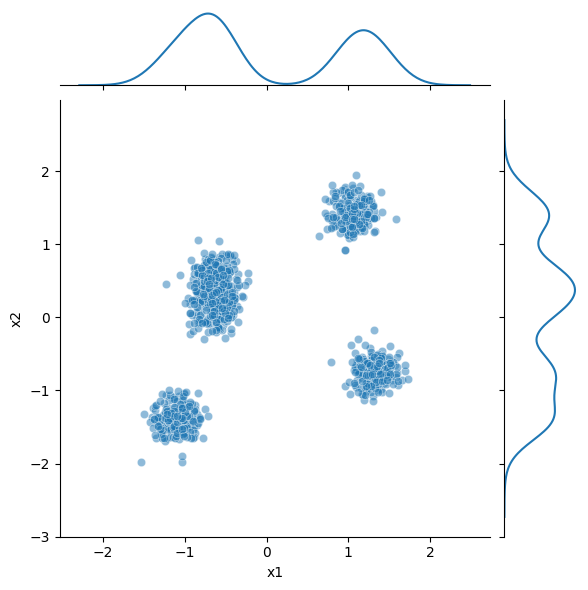

In [21]:
# take a first look at data with EDA
g2 = sns.JointGrid(data= df, x= 'x1', y= 'x2', height= 6)
g2.plot_joint(sns.scatterplot, alpha= 0.5)
g2.plot_marginals(sns.kdeplot);

Use kmeans to fit your model. And then save out predicted cluster assignments for each of your observations.

In [22]:
# fit with known clustering of 5
kmeans_blobs = KMeans(n_clusters= 5, n_init= 'auto')
kmeans_blobs.fit(df)
centers = kmeans_blobs.cluster_centers_
kmeans_labels = kmeans_blobs.labels_

df['kmeans_labels'] = kmeans_labels
df.head()

,x1,x2,label,kmeans_labels
0,1.063519,-0.714643,2,1
1,-1.246086,-1.325785,0,2
2,-0.675008,0.089202,4,0
3,0.993322,1.444389,1,3
4,1.619330,-0.490573,2,1


Select and employ an appropriate analytical method to assess the degree of agreement between your predicted vs. actual cluster assignments - i.e., external validation. You may need to do some research to identify the former. Create scatterplots for both predicted and actual cluster assignments using matplotlib's subplot() method.

In [23]:
# get silhouette coefficient
df['silhouette_coefficient'] = silhouette_samples(df, kmeans_blobs.labels_)

df.head()

,x1,x2,label,kmeans_labels,silhouette_coefficient
0,1.063519,-0.714643,2,1,0.891432
1,-1.246086,-1.325785,0,2,0.927462
2,-0.675008,0.089202,4,0,0.926842
3,0.993322,1.444389,1,3,0.925450
4,1.619330,-0.490573,2,1,0.860171


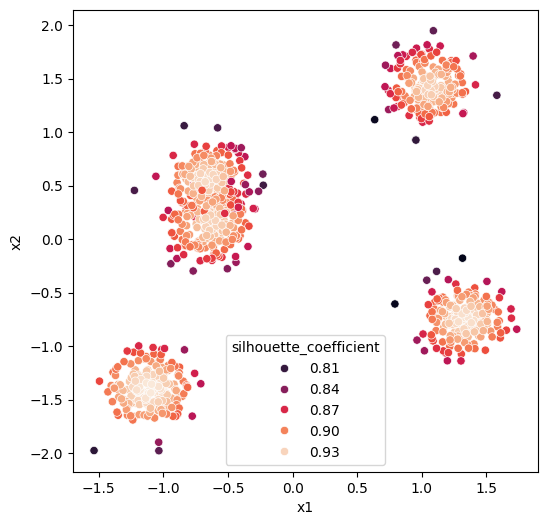

In [24]:
# plot silhouette coefficient to visually assess cluster assignments
plt.figure(figsize= (6, 6))
sns.scatterplot(x= df.x1, y= df.x2, hue= df.silhouette_coefficient, palette= 'rocket')
plt.scatter(x= df[df.silhouette_coefficient < 0].x1, y= df[df.silhouette_coefficient < 0].x2, marker= 'x', s= 50)
plt.show()

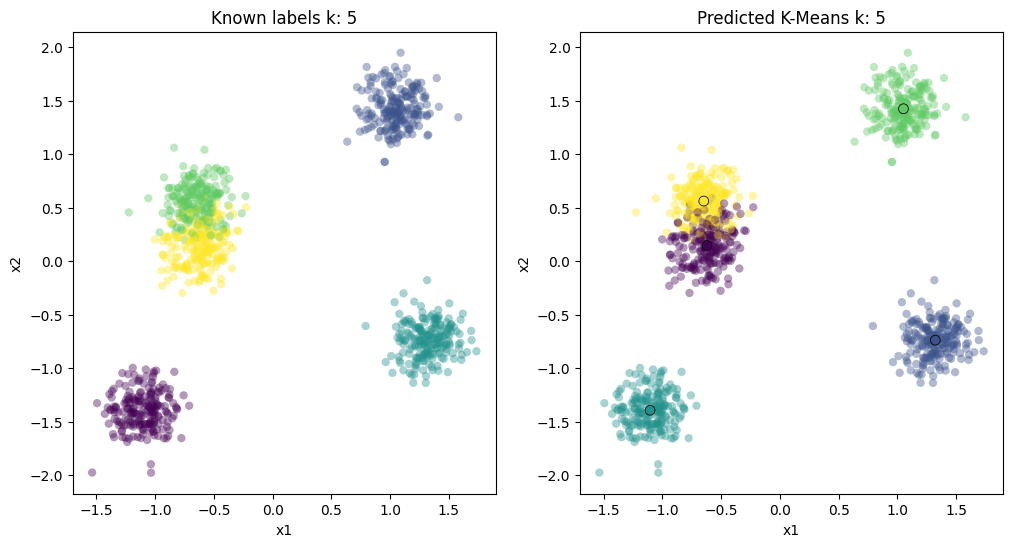

In [25]:
# create scatterplots for both predicted and actual cluster assignments using matplotlib's subplot() method
fig, (ax0, ax1) = plt.subplots(1, 2, figsize= (12, 6))

sns.scatterplot(x= df.x1, y= df.x2, c= df.label, alpha= 0.4, ax= ax0, edgecolor= 'none')
ax0.set_title(f'Known labels k: 5')

sns.scatterplot(x= df.x1, y= df.x2, c= kmeans_blobs.labels_, alpha= 0.4, ax= ax1, edgecolor= 'none')
sns.scatterplot(x= centers[:, 0], y= centers[:, 1], c= np.arange(len(centers)), ax= ax1, s= 50, edgecolor= 'black')
ax1.set_title(f'Predicted K-Means k: 5')

plt.show()

### Questions:

#### A. What method did you select to assess cluster agreement and why? (5pts)

I selected silhouette analysis because this analysis gives information on cluster cohesions and separation, which can help indicate when data points have been missassigned.

#### B. What do your results of this assessment suggest? (5pts)

That overall we had good clustering assignment, but there was some missassignment between the two overlapping clusters in the top left of the graph that the model had difficulty with.

## Problem 3a: Concepts: Interpreting SSE

Total SSE is the sum of the SSE for each separate attribute in the kmeans algorithm. What does it mean if the SSE for one variable is low for all clusters? Low for just one cluster? High for all clusters? High for just one cluster? How could you use the per variable SSE information to improve your clustering? (5pts)

If everything is low then everything in that cluster is low or low in variance. If everything is high for all clusters, you may need to scale your data. If it high for just once cluster, it is likely implying noisy data. Knowing this information could help you understand where the partitions in your dataset are and help you identify better starting points for clustering analysis.

## Problem 3b: Local and Global Objective Functions

Kmeans. For the following sets of two-dimensional points, (1) provide a sketch of how they would be split into clusters by kmeans for the given number of clusters and (2) indicate approximately where the resulting centroids would be. Assume that we are using the squared error objective funtion. If you believe that there is more than one possible solution, the please indicate whether each solution is a global or local minimum (draw pictures to represent your repsonses). Darker areas indicate higher density. Assume a uniform density within each shaded area. (6pts)

In [26]:
from sklearn.datasets import make_circles

For the following questions, I will generate an approximation of the given picture, what the kmeans clustering looks like, and then discuss the placement of the centroids after the scatterplot.

### (a) k = 3

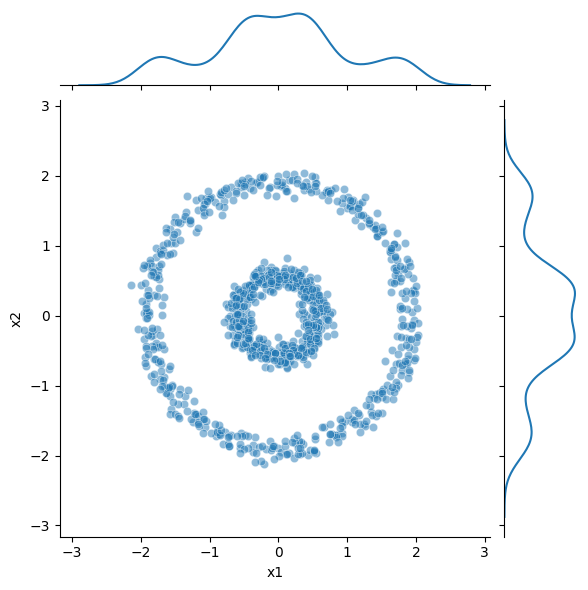

In [27]:
# generate data for two rings
X, y = make_circles(n_samples= 1000, factor= 0.3, random_state= 42, noise= 0.05)

X = StandardScaler().fit_transform(X)

circles = pd.DataFrame(X, columns= ['x1', 'x2'])

g = sns.JointGrid(data= circles, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha=.5)
g.plot_marginals(sns.kdeplot);

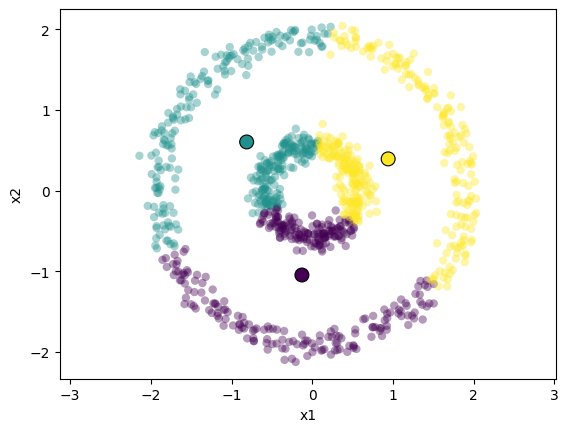

In [28]:
# fit kmeans
km = KMeans(n_clusters= 3, n_init= 'auto').fit(circles)
centers = km.cluster_centers_
labels = km.labels_
    
sns.scatterplot(x= circles.x1, y= circles.x2, alpha= 0.4, c= labels, edgecolors= 'none')
sns.scatterplot(x= centers[:, 0], y= centers[:, 1], c= np.unique(labels), s=100, edgecolor= 'black')
plt.axis('equal')
plt.show()

Because KMeans is trying to split the data into equal, globular clusters, it is not going to do a good job at clustering circles. With more clusters, you may be able to get the inner ring clustered as one cluster, but it would depend on how dense it is and how dense the outer ring is as well.

### (b) k = 2

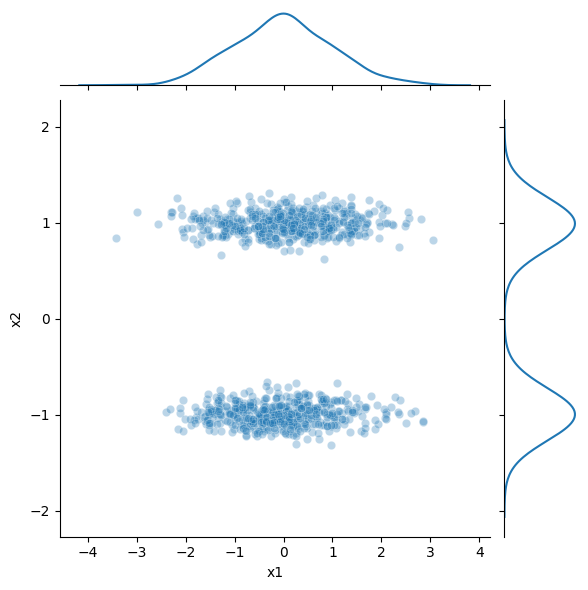

In [29]:
# generate data to approximate rectangles
X, y = make_blobs(n_samples= 1000, centers= 2, cluster_std= 0.5, n_features= 2, random_state= 8)
X = StandardScaler().fit_transform(X)

strips = pd.DataFrame(X, columns= ['x1', 'x2'])

g = sns.JointGrid(data= strips, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha=.3)
g.plot_marginals(sns.kdeplot);

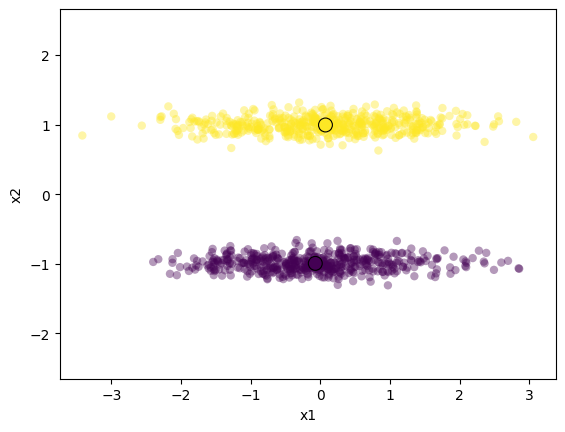

In [30]:
km = KMeans(n_clusters= 2, n_init= 'auto').fit(strips)
centers = km.cluster_centers_
labels = km.labels_
    
sns.scatterplot(x= strips.x1, y= strips.x2, alpha= 0.4, c= labels, edgecolors= 'none')
sns.scatterplot(x= centers[:, 0], y= centers[:, 1], c= np.unique(labels), s=100, edgecolor= 'black')
plt.axis('equal')
plt.show()

Another possible way for kmeans to fit the data would be to split it vertically instead of horizontally, that would be a local minimum. The above solution is the global minimum.

### (c) k = 2

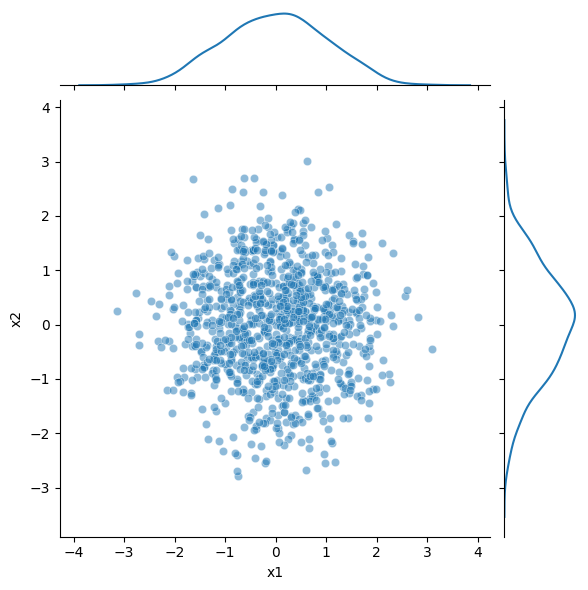

In [31]:
# generate data for overlapping circles
X, y = make_circles(n_samples= 1000, factor= .90, random_state= 42, noise= .80)

X = StandardScaler().fit_transform(X)

circle = pd.DataFrame(X, columns= ['x1', 'x2'])

g = sns.JointGrid(data= circle, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha=.5)
g.plot_marginals(sns.kdeplot);

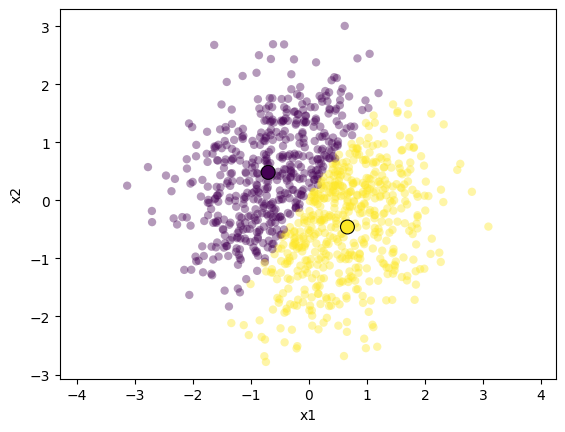

In [32]:
km = KMeans(n_clusters= 2, n_init= 'auto').fit(circle)
centers = km.cluster_centers_
labels = km.labels_
    
sns.scatterplot(x= circle.x1, y= circle.x2, alpha= 0.4, c= labels, edgecolors= 'none')
sns.scatterplot(x= centers[:, 0], y= centers[:, 1], c= np.unique(labels), s=100, edgecolor= 'black')
plt.axis('equal')
plt.show()

The split may be at different angles accross the circles depending on the density distribution of the data.

## Problem 3c: Density Clustering

Suppose we apply DBSCAN to cluster the following dataset using Euclidean distance.

In [33]:
# set up data points
points = {'A': [0, 0], 'B': [1, 1], 'C': [1, 2], 'D': [1, 3], 'E': [2, 2], 'F': [2, 1], 'G': [3, 1], 'H': [4, 4],
          'I': [5, 5], 'J': [5, 6], 'L': [6, 6], 'M': [6, 5]}

pts_list = points.items()
labels, coords = zip(*pts_list)
x, y = zip(*coords)

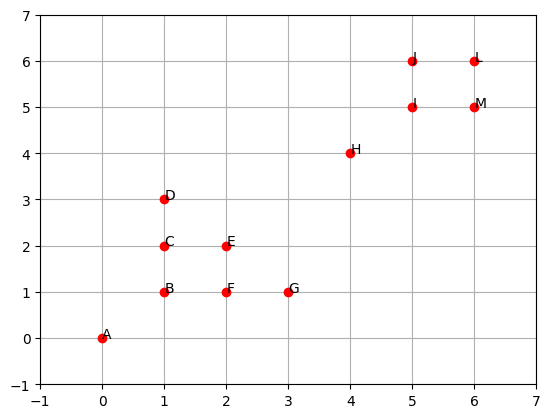

In [34]:
# set up plot
fig, ax = plt.subplots()

ax.plot(x, y, "or")
ax.grid()
ax.set_xlim(-1, 7)
ax.set_ylim(-1, 7)
for point, coord in pts_list:
    ax.annotate(point, xy= coord)

plt.show()

A point is a core point if its density (num point within EPS) is $\geq$ MinPts. Given that MinPts=3 and EPS=1, answer the following questions:
- Label all points as 'core points', 'boundary points', and 'noise'. (5pts)
- What is the clustering result (i.e., how will the data cluster)? (5pts)

#### The following points are 'core points':
- B, C, E, F, I, J, L, M

#### The following points are 'boundary points':
- D, G

#### The following points are 'noise':
- A, H

#### The points will split into the following two clusters:
- B, C, D, E, F, G
- I, L, J, M
- with A and H as outliers

## Problem 3d: Entropy vs. SSE

Assume you are given a data set of objects, each of which is assigned to one of two classes, and suppose that C1 and C2 are two clusterings produced from this data set. If entropy judges C1 to be a more accurate clustering than C2, is it necessary that SSE will also judge C1 to be a more accurate clustering than C2? (5pts)

No. SSE measures distance between clusters, while entropy is simply the ability to recover known classes.

## Problem 4: Selecting an Appropriate Clustering Algorithm

Import the following dataset: 'x4_vals.npy'.

In [35]:
# load in the dataset
x4 = np.load('x4_vals.npy')
x4[:10]

array([[-2.50582765,  4.23142098],
       [-2.01503071,  2.57790164],
       [-0.77873172,  3.73600103],
       [-1.525042  ,  2.95045747],
       [-0.61968656,  2.70325243],
       [-3.23231055,  1.56698041],
       [-0.98643036,  3.53808359],
       [ 0.30636368,  4.18990308],
       [-1.5958858 ,  3.00782344],
       [-0.4263694 ,  2.34199502]])

In [36]:
# create a dataframe from the dataset
x4_df = pd.DataFrame(x4, columns= ['x1', 'x2'])

In [37]:
# scale the data
x4_scaled = pd.DataFrame(std_scaler.fit_transform(x4_df[['x1', 'x2']]), columns= ['x1', 'x2'])

In [38]:
# load labels
y4 = np.load('y4_vals.npy')

In [39]:
# add labels to dataframe
x4_scaled['label'] = pd.Series(y4)
x4_scaled.head()

,x1,x2,label
0,-1.371927,-0.451673,0.0
1,-1.232381,-1.558762,0.0
2,-0.880869,-0.783374,0.0
3,-1.093064,-1.309323,0.0
4,-0.835648,-1.474836,0.0


In [55]:
x4_scaled.label.value_counts()

label
0.0    125
1.0    125
2.0    125
3.0    125
Name: count, dtype: int64

Conduct an initial EDA to evaluate the data. Create at least two different types of visualizations to help you evaluate possible values for K (the number of clusters).

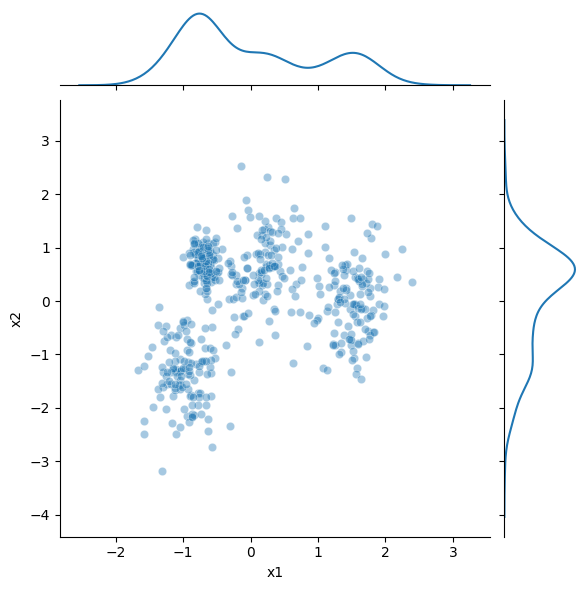

In [40]:
# look at density plot
g = sns.JointGrid(data= x4_scaled, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha= 0.4)
g.plot_marginals(sns.kdeplot);

Our EDA suggests at least 3, but probably 4 clusters.

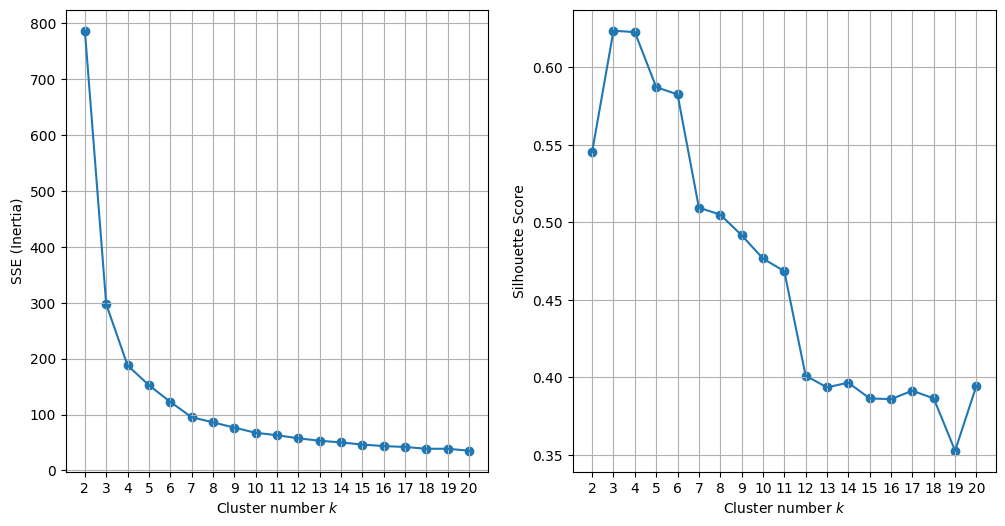

In [41]:
# attempt kmeans to get SSE(Inertia) and Silhouette Score
sse_sil = np.empty((0, 3))
for k in np.arange(2, 21, 1):
    kmeans2 = KMeans(n_clusters= k, n_init= 10)
    kmeans2.fit(x4_scaled)
    labels = kmeans2.labels_

    sse_sil = np.vstack([sse_sil, np.array([k, kmeans2.inertia_, silhouette_score(x4_scaled, labels)])])

fig, (ax1, ax2) = plt.subplots(nrows= 1, ncols= 2, figsize= (12, 6))

ax1.scatter(x= sse_sil[:, 0], y= sse_sil[:, 1])
ax1.plot(sse_sil[:, 0], sse_sil[:, 1])
ax1.grid()
ax1.set_xlabel('Cluster number $k$')
ax1.set_ylabel('SSE (Inertia)')
ax1.set_xticks(ticks= np.arange(2, 21, 1))

ax2.scatter(x= sse_sil[:, 0], y= sse_sil[:, 2])
ax2.plot(sse_sil[:, 0], sse_sil[:, 2])
ax2.grid()
ax2.set_xlabel('Cluster number $k$')
ax2.set_ylabel('Silhouette Score')
ax2.set_xticks(ticks= np.arange(2, 21, 1))
plt.show()

Our SSE(Inertia) and Silhouette Score suggest probably 4 clusters.

Parameterize and implement the following clustering algorithms using this dataset: Kmeans, Gaussian Mixture Model, DBSCAN, Agglomerative Hierarchical.

In [42]:
# I had to make a copy of the dataframe without the label, when I ran it with the label column I was getting an error that said I could not indicate
# column and label at the same time
x4_no_labels = x4_scaled.drop(columns= ['label'])
x4_no_labels.head()

,x1,x2
0,-1.371927,-0.451673
1,-1.232381,-1.558762
2,-0.880869,-0.783374
3,-1.093064,-1.309323
4,-0.835648,-1.474836


In [43]:
# implement Kmeans, GMM, and Agglo algorithms here
np.random.seed(42)

sil = np.empty((0, 7))
db = np.empty((0, 7))
bic_aic = np.empty((0, 3))

for k in np.arange(2, 21, 1, dtype= int):

    kmeans3 = KMeans(n_clusters= k, n_init= 10).fit(x4_no_labels)
    kmeans3_labels = kmeans3.labels_

    gm = GaussianMixture(n_components= k).fit(x4_no_labels)
    gm_labels = gm.predict(x4_no_labels)

    sil_by_linkage = np.empty(0)
    db_by_linkage = np.empty(0)
    for link in ['ward', 'single', 'complete', 'average']:
        agglo = AgglomerativeClustering(n_clusters= k, linkage= link).fit(x4_no_labels)
        agglo_labels = agglo.labels_

        sil_by_linkage = np.append(sil_by_linkage, silhouette_score(X= x4_no_labels, labels= agglo_labels))
        db_by_linkage = np.append(db_by_linkage, davies_bouldin_score(X= x4_no_labels, labels= agglo_labels))

    sil = np.vstack([sil,
                     np.append(np.array([k,
                                         silhouette_score(X= x4_no_labels, labels= kmeans3_labels),
                                         silhouette_score(X= x4_no_labels, labels= gm_labels)
                                        ]),
                               sil_by_linkage)
                    ])

    db = np.vstack([db,
                    np.append(np.array([k,
                                         davies_bouldin_score(X= x4_no_labels, labels= kmeans3_labels),
                                         davies_bouldin_score(X= x4_no_labels, labels= gm_labels)
                                        ]),
                              db_by_linkage)])

    bic_aic = np.vstack([bic_aic,
                         np.array([k,
                                   gm.bic(X= x4_no_labels),
                                   gm.aic(X= x4_no_labels)])])

silhouette_leaderboard = \
pd.DataFrame(sil,
             columns= ['k',
                    'kmeans',
                       'gmm',
                       'agg_ward',
                       'agg_single',
                       'agg_complete',
                       'agg_average',
                    ])
davies_bouldin_leaderboard = \
pd.DataFrame(db,
             columns= ['k',
                       'kmeans',
                       'gmm',
                       'agg_ward',
                       'agg_single',
                       'agg_complete',
                       'agg_average',
                    ])

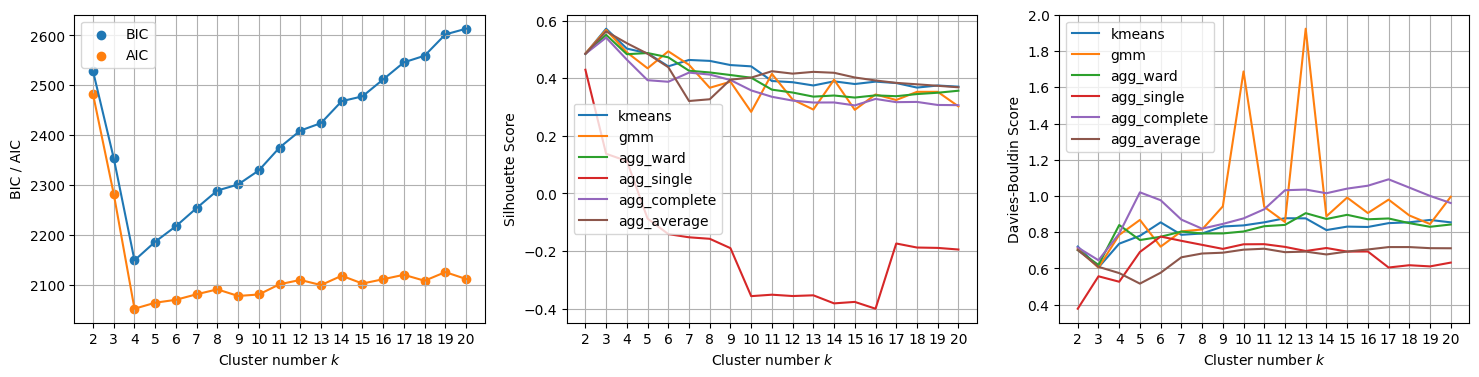

In [44]:
# plot leaderboard results
fig, (ax1, ax2, ax3) = plt.subplots(nrows= 1, ncols= 3, figsize= (18, 4))

ax1.scatter(x= bic_aic[:, 0], y= bic_aic[:, 1], label= 'BIC')
ax1.plot(bic_aic[:, 0], bic_aic[:, 1])
ax1.scatter(x= bic_aic[:, 0], y= bic_aic[:, 2], label= 'AIC')
ax1.plot(bic_aic[:, 0], bic_aic[:, 2])
ax1.set_xlabel('Cluster number $k$')
ax1.set_ylabel('BIC / AIC')
ax1.grid()
ax1.set_xticks(ticks= np.arange(2, 21, 1))
ax1.legend()

silhouette_leaderboard.drop(columns= ['k']).plot(ax= ax2)
ax2.set_xlabel('Cluster number $k$')
ax2.set_ylabel('Silhouette Score')
ax2.grid()
ax2.set_xticks(ticks= np.arange(0, silhouette_leaderboard.shape[0], 1),
               labels= np.arange(silhouette_leaderboard.k.min(), silhouette_leaderboard.k.max()+1, dtype= int))
ax2.legend()

davies_bouldin_leaderboard.drop(columns= ['k']).plot(ax= ax3)
ax3.set_xlabel('Cluster number $k$')
ax3.set_ylabel('Davies-Bouldin Score')
ax3.set_xticks(ticks= np.arange(0, davies_bouldin_leaderboard.shape[0], 1),
               labels= np.arange(davies_bouldin_leaderboard.k.min(), davies_bouldin_leaderboard.k.max()+1, dtype= int))
ax3.grid()
ax3.legend()

plt.show()

### Best $k$ and method from Silhouette Leaderboard

In [45]:
best_locs = np.where(silhouette_leaderboard == silhouette_leaderboard.drop(columns= 'k').max().max())
optimal_ks = np.unique(best_locs[0])
optimal_algo = np.unique(best_locs[1])
silhouette_leaderboard.iloc[optimal_ks][np.append('k', silhouette_leaderboard.columns[optimal_algo].values)]

,k,kmeans
1,3.0,0.571856


### Best $k$ and method from Davies-Bouldin Leaderboard

In [46]:
best_locs = np.where(davies_bouldin_leaderboard == davies_bouldin_leaderboard.drop(columns= 'k').min().min())
optimal_ks = np.unique(best_locs[0])
optimal_algo = np.unique(best_locs[1])
davies_bouldin_leaderboard.iloc[optimal_ks][np.append('k', davies_bouldin_leaderboard.columns[optimal_algo].values)]

,k,agg_single
0,2.0,0.377319


### Best $k$ from Gaussian Mixture Information Criteria

In [47]:
print(f'BIC: {bic_aic[bic_aic[:, 1].argmin()]}')
print(f'AIC: {bic_aic[bic_aic[:, 2].argmin()]}')

BIC: [   4.         2149.2892728  2052.35328653]
AIC: [   4.         2149.2892728  2052.35328653]


### Retrain models with optimum $k$ values

In [52]:
kmeans = KMeans(n_clusters= 3, n_init= 10).fit(x4_no_labels)
x4_scaled['km_label'] = kmeans.labels_

agglo = AgglomerativeClustering(n_clusters= 2, linkage= 'single').fit(x4_no_labels)
x4_scaled['agg_label'] = agglo.labels_

gm = GaussianMixture(n_components= 4).fit(x4_no_labels)
x4_scaled['gm_label'] = gm.predict(x4_no_labels)

#### DBSCAN

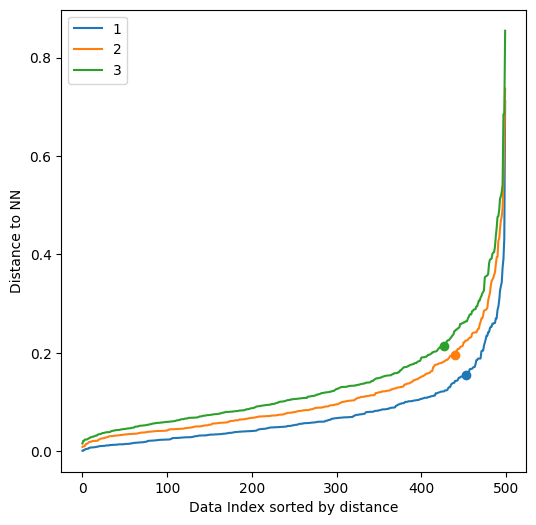

In [48]:
# start with nearest neighbors
neighbors = 3
nbrs = NearestNeighbors(n_neighbors= neighbors + 1).fit(x4_no_labels)
distances, indices = nbrs.kneighbors(x4_no_labels)
distances = np.sort(distances, axis= 0)

opt_esp_minpts = np.empty((0, 2))
plt.figure(figsize= (6, 6))
for n in np.arange(1, neighbors + 1):

    lndf = np.linspace(start= distances[0, n], stop= distances[-1, n], num= int(distances.shape[0]))

    distA = np.concatenate([np.arange(1, distances.shape[0] + 1) / distances.shape[0], distances[:, n]]).reshape(2, -1).T
    distB = np.concatenate([np.arange(1, lndf.shape[0] + 1) / lndf.shape[0], lndf]).reshape(2, -1).T

    all2all = cdist(XA = distA, XB= distB)
    idx_opt = all2all.min(axis= 1).argmax()

    opt_esp_minpts = np.vstack([opt_esp_minpts, np.array([n, distances[idx_opt, n]])])

    plt.plot(distances[:, n], label= n)
    plt.scatter(x= idx_opt, y= distances[idx_opt, n])

plt.legend()
plt.xlabel('Data Index sorted by distance')
plt.ylabel('Distance to NN')
plt.show()

In [49]:
opt_esp_minpts

array([[1.        , 0.15422329],
       [2.        , 0.19636211],
       [3.        , 0.21318469]])

In [50]:
dbscan = DBSCAN(min_samples= int(opt_esp_minpts[-1, 0] + 1), eps= opt_esp_minpts[-1, 1] + 0.01).fit(x4_no_labels[['x1', 'x2']])
x4_scaled['dbs_label'] = dbscan.labels_
dbs_cluster_lbls, dbs_cluster_cnts = np.unique(x4_scaled.dbs_label, return_counts= True)
dbs_clusters = dict(zip(dbs_cluster_lbls, dbs_cluster_cnts))

df_dbscan = x4_scaled[x4_scaled.dbs_label != -1].copy()

Create a plot of your results for each algorithm that distinguishes clusters by color.

C:\Users\farrj\AppData\Local\Temp\ipykernel_27124\3223246418.py:19: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


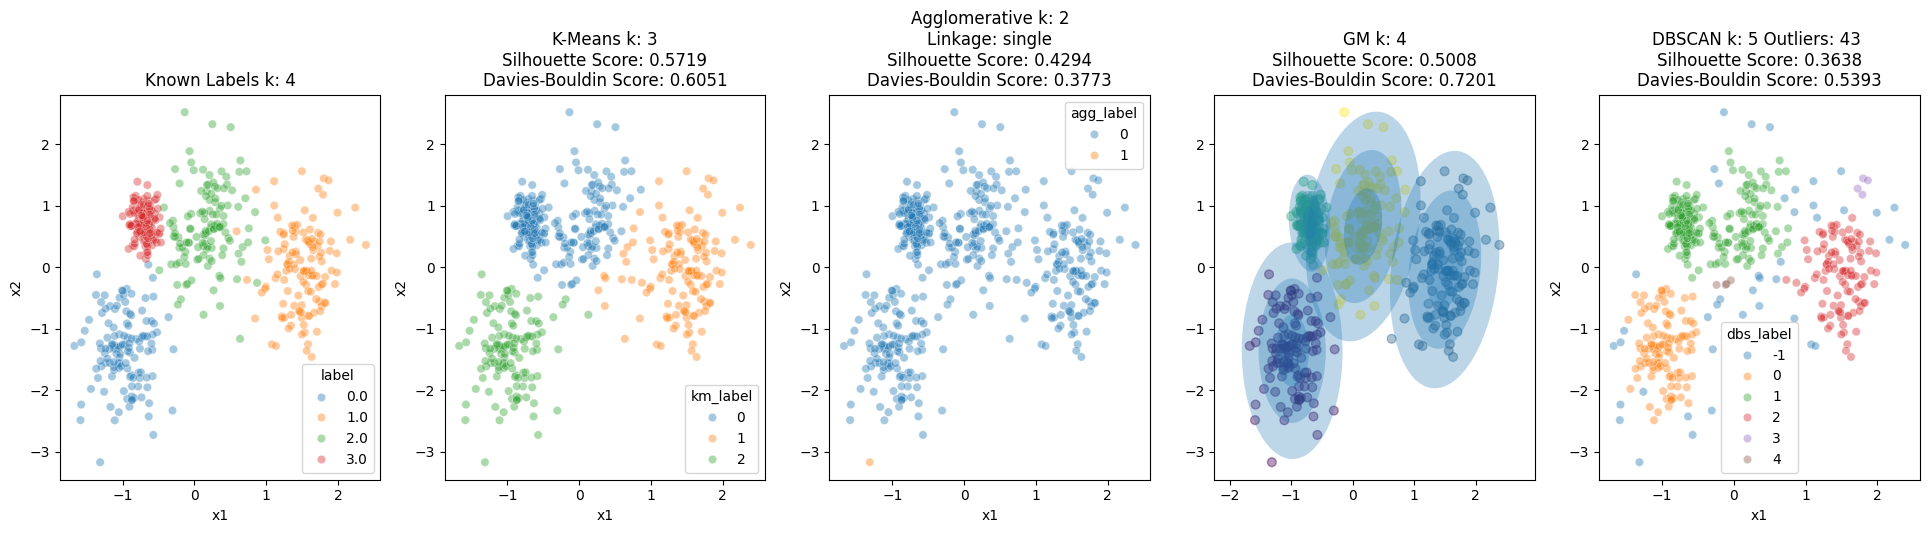

In [53]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows= 1, ncols= 5, figsize= (24, 5))

sns.scatterplot(data= x4_scaled, x= 'x1', y= 'x2', hue= 'label', alpha= 0.4, palette= 'tab10', ax= ax0)
ax0.set_title(f'Known Labels k: {x4_scaled.label.nunique()}')

sns.scatterplot(data= x4_scaled, x= 'x1', y= 'x2', hue= 'km_label', legend= 'full', alpha= 0.4, palette= 'tab10',
                ax= ax1)
ax1.set_title(f'K-Means k: {kmeans.n_clusters}\nSilhouette Score: {np.round(silhouette_score(X= x4_scaled[["x1", "x2"]], labels= x4_scaled.km_label), 4)}\nDavies-Bouldin Score: {np.round(davies_bouldin_score(X= x4_scaled[["x1", "x2"]], labels= x4_scaled.km_label), 4)}')

sns.scatterplot(data= x4_scaled, x= 'x1', y= 'x2', hue= 'agg_label', legend= 'full', alpha= 0.4, palette= 'tab10',
                ax= ax2)
ax2.set_title(f'Agglomerative k: {agglo.n_clusters}\nLinkage: {agglo.linkage}\nSilhouette Score: {np.round(silhouette_score(X= x4_scaled[["x1", "x2"]], labels= x4_scaled.agg_label), 4)}\nDavies-Bouldin Score: {np.round(davies_bouldin_score(X= x4_scaled[["x1", "x2"]], labels= x4_scaled.agg_label), 4)}')

plot_gmm(gmm= gm, X= x4_scaled[["x1", "x2"]].values, ax= ax3)
ax3.set_title(f'GM k: {gm.n_components}\nSilhouette Score: {np.round(silhouette_score(X= x4_scaled[["x1", "x2"]], labels= x4_scaled.gm_label), 4)}\nDavies-Bouldin Score: {np.round(davies_bouldin_score(X= x4_scaled[["x1", "x2"]], labels= x4_scaled.gm_label), 4)}')

sns.scatterplot(data= x4_scaled, x= 'x1', y= 'x2', hue= 'dbs_label', legend= 'full', alpha= 0.4, palette= 'tab10',
                ax= ax4)
ax4.set_title(f'DBSCAN k: {len(dbs_cluster_lbls[dbs_cluster_lbls != -1])} Outliers: {dbs_clusters[-1]} \nSilhouette Score: {np.round(silhouette_score(X= df_dbscan[["x1", "x2"]], labels= df_dbscan.dbs_label), 4)}\nDavies-Bouldin Score: {np.round(davies_bouldin_score(X= df_dbscan[["x1", "x2"]], labels= df_dbscan.dbs_label), 4)}')

plt.show()

Select the algorithm/parameters that you believe provides the 'best' clustering results. Note: you may find it helpful to iterate between clustering algorithms/parameterizations and related graphs to make this selection.

- If we were to go only off the best Davies-Bouldin Score, the best result would be the Agglomerative clustering with 2 clusters using single linkage. However, this is not supported by our EDA, so I would say this is probably not the actual 'best' clustering result.
- If we look at the Silhouette Score, K-Means with 3 clusters has the highest score. However, GM with 4 clusters is not very far behind it.
  - Our EDA does not discount 3 clusters, but it seems to look more like 4 clusters. Four clusters is also what our initial SSE(Inertia)/Silhouette Score indicated (although again, 3 was not completely discounted).

C:\Users\farrj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
C:\Users\farrj\AppData\Local\Temp\ipykernel_27124\1004644632.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color= plt.cm.get_cmap("Spectral")(float(j)/ k)
C:\Users\farrj\AppData\Local\Temp\ipykernel_27124\1004644632.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color= plt.cm.get_cmap("Spectral")(float(j)/ k)
C:\Users\farrj\AppData\Local\Packages\PythonSoftwareFoundation.Pyt

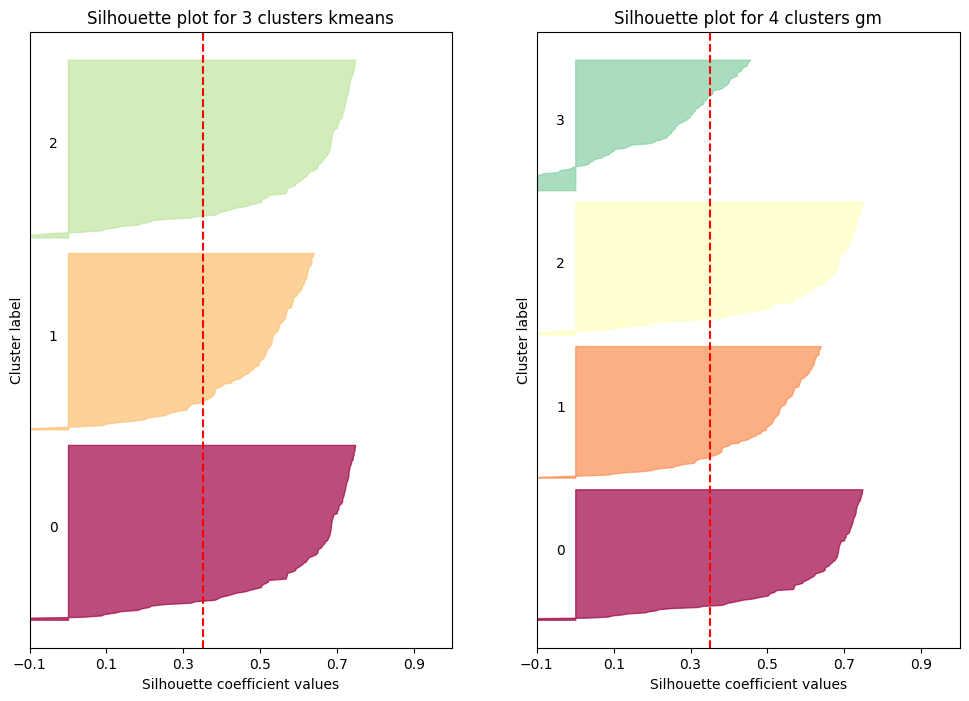

In [54]:
silhouette_value_by_k = np.empty((0, 2))

k_values = np.arange(3, 5, 1)
plt.figure(figsize= (len(k_values)*6, 8))

for i, k in enumerate(k_values):
    # get the needed labels
    #kmeans = KMeans(n_clusters= 3, n_init= 10).fit(x4_no_labels)
    km_pred_labels = kmeans.predict(x4_no_labels)

    #gm = GaussianMixture(n_components= 4).fit(x4_no_labels)
    gm_pred_labels = gm.predict(x4_no_labels)

    # compute the silhouette scores for each model
    km_sil_avg = silhouette_score(x4_no_labels, km_pred_labels)
    sample_silhouette_values = silhouette_samples(x4_no_labels, km_pred_labels)

    silhouette_value_by_k = np.vstack([silhouette_value_by_k, [k, sample_silhouette_values.mean()]])

    gm_sil_avg = silhouette_score(x4_no_labels, gm_pred_labels)
    sample_silhouette_values = silhouette_samples(x4_no_labels, gm_pred_labels)

    silhouette_value_by_k = np.vstack([silhouette_value_by_k, [k, sample_silhouette_values.mean()]])

    plt.subplot(1, len(k_values), i+1)
    y_lower = 10

    models = ['kmeans', 'gm']
    for j in range(k):
        model = models[k-3]
        if j == 2:
            ith_cluster_silhouette_values= sample_silhouette_values[km_pred_labels == j]
            ith_cluster_silhouette_values.sort()
            size_cluster_j= ith_cluster_silhouette_values.shape[0]
            y_upper= y_lower + size_cluster_j

            color= plt.cm.get_cmap("Spectral")(float(j)/ k)
            plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor= color,
                edgecolor= color, alpha= 0.7)

            plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
            y_lower= y_upper + 10

        else:
            ith_cluster_silhouette_values= sample_silhouette_values[gm_pred_labels == j]
            ith_cluster_silhouette_values.sort()
            size_cluster_j= ith_cluster_silhouette_values.shape[0]
            y_upper= y_lower + size_cluster_j

            color= plt.cm.get_cmap("Spectral")(float(j)/ k)
            plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor= color,
                edgecolor= color, alpha= 0.7)

            plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
            y_lower= y_upper + 10

    plt.title("Silhouette plot for {} clusters {}".format(k, model))
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x= silhouette_avg, color= "red", linestyle= "--")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.xlim([-0.1, 1.0])

plt.show()

### Questions:

#### A. What method(s) did you use to identify an appropriate value for K? Why did you select this method(s)? (5pts)

- I used a combination of the elbow method, silhouette score, along with the EDA method to make sure I wasn't overlooking any abnormalities in the data. These methods all have different strengths and weaknesses and are best when used together.

#### B. What value did you select for K? Does your EDA support this choice? (5pts)

- Looking at everything together, I would select a K of 4 which is supported by my EDA.

#### C. Why is the algorithm that you selected for your final clustering model the best choice among those you evaluated? (5pts)

- I would select the GM with 4 clusters because it is supported by my EDA and has a Silhouette Score that is second only to KMeans by a small amount (less than 0.01 of a difference).

## Problem 5: Comparing Algorithms

Compare the relative strengths and weaknesses of the clustering methods listed in Problem 4. Include your observations in a table form. (10pts)

In [57]:
algorithm = ['KMeans', 'Agglomerative', 'Gaussian Mixtures', 'DBSCAN']
strengths = {'KMeans': ['simple', 'fast'], 'Agglomerative': ['can handle differently sized population clusters', 'possibility to identify outliers depending on linkage'],
             'Gaussian Mixtures': ['can handle differently sized population clusters', 'probablilistic'],
             'DBSCAN': ['can handle differently sized and shaped population clusters', 'can identify outliers']}
weaknesses = {'KMeans': ['does not handle non-globular cluster data well', 'struggles with outliers'], 'Agglomerative':
              ['no global objective', 'can be computationally expensive'], 'Gaussian Mixtures':
              ['does not handle clusters with small populations well', 'struggles with outliers'], 'DBSCAN':
              ['does not handle clusters with different densities well', 'can be computationally expensive']}        

In [64]:
comp_algs = pd.DataFrame(index= algorithm, columns= ["strengths", "weaknesses"])
comp_algs['strengths'] = strengths
comp_algs['weaknesses'] = weaknesses

In [65]:
comp_algs

,strengths,weaknesses
KMeans,"[simple, fast]",[does not handle non-globular cluster data wel...
Agglomerative,[can handle differently sized population clust...,"[no global objective, can be computationally e..."
Gaussian Mixtures,[can handle differently sized population clust...,[does not handle clusters with small populatio...
DBSCAN,[can handle differently sized and shaped popul...,[does not handle clusters with different densi...
